In [1]:
# usual imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline
import datetime as dt
from  scipy.stats import chisquare
from scipy.stats import chi2_contingency


# stats tests 
from scipy.stats import ttest_ind

# ml imports
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn import datasets

In [2]:
# read in the data
data = pd.read_csv("KaggleV2-May-2016.csv", parse_dates=["AppointmentDay", "ScheduledDay"])

### Initial data cleaning
###### For details see other notebooks

In [3]:
# filter out negative age
data = data[data.Age >=0]

# This turns the No-show variable into a binary of true or false where true means a no-show.  
data['no_show_bi'] = data["No-show"]== 'Yes'

# Create a column that is the day of the week of the appointment 
data["appointment_day"] = data["AppointmentDay"].dt.weekday_name

# Remove the Saturday appointments as they are clearly outliers. 
data= data[data["appointment_day"] != "Saturday"]

# create a column for the time between when a patient scheduled the appointment to the appointment.
data["wait"] = (data["AppointmentDay"].dt.date - data["ScheduledDay"].dt.date)

# drop negative wait time rows. 
data = data[data['wait'] >= "0 days"]

# remove outlier neighbourhoods
remove_list = ["ILHA DO BOI", "ILHA DO FRADE", "AEROPORTO", "ILHAS OCEÂNICAS DE TRINDADE","PARQUE INDUSTRIAL"]
data= data[~data.Neighbourhood.isin(remove_list)]

## Implement Binning System 
### Age Binning

In [4]:
def bin_age(df):
    '''Creates a function to turn age into 6 groups of binned ages.'''
                        # bin ranges 0-3, 4-7, 8-27, 28-40, 41-60, 61 < 
    if df["Age"] <4:
        return 2
    elif df["Age"] <8:
        return 5
    elif df["Age"] <28:
        return 16
    elif df["Age"] <41:
        return 34
    elif df["Age"] <61:
        return 51
    else:
        return 70

In [5]:
# apply binning function
data["Age_Binned"]= data.apply(bin_age, axis=1)

### Wait time binning

In [6]:
# turn wait time from time delta to an int
data["days_waiting"] = data["wait"].dt.days

In [7]:
def bin_wait_time(df):
    '''Creates a function to turn wait_time into 5 groups of binned wait times .'''
                        # bin ranges 0, 1, 2-4, 5-9, 10 < 
    col="days_waiting"
    if df[col]   <1:
        return 0
    elif df[col] <2:
        return 1
    elif df[col] <5:
        return 3
    elif df[col] <10:
        return 7
    else:
        return 15

In [8]:
# Apply the binning function. 
data["Wait_Binned"]= data.apply(bin_wait_time, axis=1)

# MACHINE LEARNING SECTION

In [9]:
data.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'no_show_bi', 'appointment_day', 'wait', 'Age_Binned', 'days_waiting',
       'Wait_Binned'],
      dtype='object')

In [10]:
data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,no_show_bi,appointment_day,wait,Age_Binned,days_waiting,Wait_Binned
0,2.987250e+13,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,False,Friday,0 days,70,0,0
1,5.589978e+14,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,False,Friday,0 days,51,0,0
2,4.262962e+12,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,False,Friday,0 days,70,0,0
3,8.679512e+11,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,False,Friday,0 days,16,0,0
4,8.841186e+12,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,False,Friday,0 days,51,0,0


## Wrangle the data into a form where ml can be applied

In [11]:
# Run cell to run ML on all statistically significant predictor variables. 
X_create= data.set_index("AppointmentID")[['Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes','SMS_received','appointment_day', 'Age_Binned', 'Wait_Binned']]
X_create["Age_Binned"]=X_create["Age_Binned"].astype(str)
X_create["Wait_Binned"]=X_create["Wait_Binned"].astype(str)

y_create = data.set_index("AppointmentID")[["No-show"]]
y_create["No-show"][y_create["No-show"]=="Yes"] = 1
y_create["No-show"][y_create["No-show"]=="No"]  = 0

X_create.head()

,Neighbourhood,Scholarship,Hipertension,Diabetes,SMS_received,appointment_day,Age_Binned,Wait_Binned
AppointmentID,,,,,,,,
5642903,JARDIM DA PENHA,0,1,0,0,Friday,70,0
5642503,JARDIM DA PENHA,0,0,0,0,Friday,51,0
5642549,MATA DA PRAIA,0,0,0,0,Friday,70,0
5642828,PONTAL DE CAMBURI,0,0,0,0,Friday,16,0
5642494,JARDIM DA PENHA,0,1,1,0,Friday,51,0


In [12]:
# make the categorical variables into bool columns, drop the first to avoid redundancy. 
X = pd.get_dummies(X_create, drop_first=True).values

# This puts the y values which are our targets into the correct format for ml 
y = np.array(list(y_create["No-show"]))

In [13]:
# we split the data at this point to set aside 10% of the data for model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=12)

## Logistic Regression with IMBLEARN oversampling 

In [14]:
# We split the data a second time in order to do resampling on this second version. 
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train,
                                                  test_size = .1,
                                                  random_state=12)

# Run a SMOTE resampling on the second training data split to balance out the no-shows and shows appointments for ml
smote = SMOTE(random_state=12 , ratio='minority') 
x_train_res, y_train_res = smote.fit_sample(X_train2, y_train2)

In [15]:
# We run the logistic Regression CV on the rebalanced data, with F1 scoring.  
searchCV_SMOTE = LogisticRegressionCV(cv=10, scoring= "f1")
searchCV_SMOTE.fit(x_train_res, y_train_res)
y_pred_LR = searchCV_SMOTE.predict(X_test)

In [16]:
# compute the AUROC score 
metrics.roc_auc_score(y_test,searchCV_SMOTE.predict_proba(X_test)[:,1])

0.71513437636769273

In [20]:
# computer the f1_score
metrics.f1_score(y_test, y_pred_LR)

0.44188044679022959

In [21]:
# run through a bunch of thresholds and get the f1-score's for each. 
thresh_list = np.arange(0.44,0.55,0.01)  
lr_cv_proba = searchCV_SMOTE.predict_proba(X_test)[:,1]
for value in thresh_list:
    prediction = lr_cv_proba > value
    f1_score_v = metrics.f1_score(y_test,prediction)
    print(value , f1_score_v )

0.44 0.438243468594
0.45 0.438430311231
0.46 0.437406769937
0.47 0.437288531093
0.48 0.437270029674
0.49 0.43924783028
0.5 0.44188044679
0.51 0.440976591996
0.52 0.4396405782
0.53 0.43910991234
0.54 0.436333240457
0.55 0.434545193275


#### Logitic Regression with all the variables and rebalancing gave a max f1-score of 0.441 with a threshould of 0.5

In [19]:
# we see that a accuracy score is around 60%
accuracy_score(y_test, y_pred_LR)

0.58824594765915061

## Impliment K-nearest neighbors Classifier : rebalanced data

In [23]:
# run with the top variables 
knn = KNeighborsClassifier(n_neighbors=18, n_jobs=-1 ).fit(x_train_res, y_train_res)
knn.score(X_test,y_test)
y_pred_knn = knn.predict(X_test)
metrics.roc_auc_score(y_test,knn.predict_proba(X_test)[:,1])

0.67702377860113971

In [24]:
# scores with n-neighbors = 18
print(metrics.f1_score(y_test, y_pred_knn))

0.365886160289


In [25]:
thresh_list = np.arange(0.15,0.25,0.01)  # k = 18 - 0.414 - thresh of 0.22
knn_proba = knn.predict_proba(X_test)[:,1]
for value in thresh_list:
    knn_sn_th = knn_proba > value
    f1_score_v = metrics.f1_score(y_test,knn_sn_th)
    print(value , f1_score_v )
    knn_sn_thresh = 0
    f1_score_v = 0

0.15 0.409230140903
0.16 0.409230140903
0.17 0.413597733711
0.18 0.413597733711
0.19 0.413597733711
0.2 0.413597733711
0.21 0.413597733711
0.22 0.413597733711
0.23 0.409644250089
0.24 0.409644250089


#### K nearest neighbors had a max f1-score of 0.414 with a threshold of  0.22 

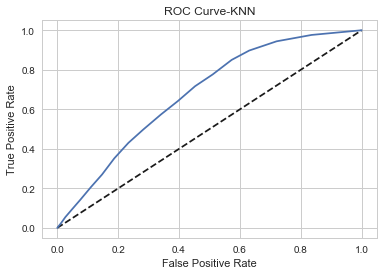

In [26]:
y_pred_prob = knn.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve-KNN')
plt.show()
#plt.savefig('roc_knn.png') # saves the plot 

## Random Forest Classifier

In [65]:
# run random forest - all variables, not rebalanced
rfc = RandomForestClassifier(n_jobs=-1, random_state = 42, max_depth= 30, min_samples_leaf= 1, n_estimators= 9)
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.79344381055872504

In [66]:
y_pred_RF = rfc.predict(X_test)

In [67]:
metrics.roc_auc_score(y_test,rfc.predict_proba(X_test)[:,1])

0.71327799954556381

In [68]:
print(classification_report(y_test, y_pred_RF))

             precision    recall  f1-score   support

          0       0.81      0.98      0.88      8810
          1       0.43      0.07      0.11      2233

avg / total       0.73      0.79      0.73     11043



In [79]:
y_pred_prob_RF = rfc.predict_proba(X_test)[:,1] > 0.23

In [80]:
metrics.f1_score(y_test,y_pred_prob_RF)

0.42728852838933951

In [91]:
print(classification_report(y_test, y_pred_prob_RF))

             precision    recall  f1-score   support

          0       0.90      0.58      0.71      8810
          1       0.31      0.74      0.43      2233

avg / total       0.78      0.61      0.65     11043



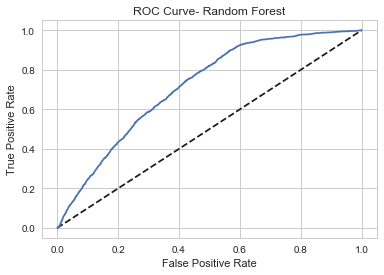

In [92]:
y_pred_prob = rfc.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Random Forest')
plt.show()

### Grid Search for Random Forest Hyperparameters 

For Grid Search CV : scoring can be  =  f1, accuracy, recall, or precision    

In [283]:
rfc = RandomForestClassifier(n_jobs=-1, random_state = 36) 
 
# Use a grid over parameters of interest
param_grid = { 
           "n_estimators" : [24,26,28], # [1,3,5,7,9, 18, 27], #36, 45, 54, 63],
           "max_depth" : [30,35,40], #[30, 32, 34, 36, 38, 40,42,45,48,51,55] ,#30, 32, 34, 36, 38, 40, 42],
           "min_samples_leaf" : [8,10,12]}
 
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3, scoring= "f1" , n_jobs=-1)
CV_rfc.fit(x_train_res, y_train_res)
print (CV_rfc.best_params_)

{'max_depth': 40, 'min_samples_leaf': 8, 'n_estimators': 28}


## RF on rebalanced data. 

In [27]:
# run random forest  - We optimized the hyperparameters through grid search and used them below
rfc_sm = RandomForestClassifier(n_jobs=-1, random_state = 36,max_depth= 40, min_samples_leaf= 8, n_estimators=28) 
rfc_sm.fit(x_train_res, y_train_res)
rf_sm = rfc_sm.predict(X_test)
rfc_sm.score(X_test, y_test)

0.67861994023363215

In [28]:
print("ROC_AUC = ")
print(metrics.roc_auc_score(y_test,rfc_sm.predict_proba(X_test)[:,1]))
print("F1 Score = ")
print(metrics.f1_score(y_test,rf_sm))

ROC_AUC = 
0.719657617423
F1 Score = 
0.428778367938


In [31]:
thresh_list = np.arange(0.4,0.55,0.01)
y_rf_sm = rfc_sm.predict_proba(X_test)[:,1] 

for value in thresh_list:
    knn_sn_th = y_rf_sm > value
    f1_score_v = metrics.f1_score(y_test,knn_sn_th)
    print(value , f1_score_v )
    knn_sn_thresh = 0
    f1_score_v = 0

0.4 0.43739151996
0.41 0.437642875286
0.42 0.438310005184
0.43 0.436290860574
0.44 0.437772925764
0.45 0.435025877745
0.46 0.434907010014
0.47 0.4345657277
0.48 0.43401937046
0.49 0.430107526882
0.5 0.428778367938
0.51 0.425861784595
0.52 0.420535411725
0.53 0.417218543046
0.54 0.411467724486
0.55 0.402324709411


#### The Random Forest with all the variables and rebalancing had a max f1-score of 0.438 with a threshold of greater than 0.42 

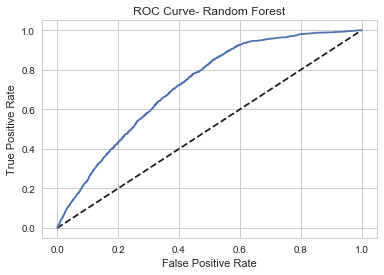

In [372]:
y_pred_rfsm = rfc_sm.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rfsm)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Random Forest')
plt.show()

#plt.savefig('roc_rf.png') # saves the plot 